In [6]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns; 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

### Данные c обработкой

Считываем файл в DataFrame

In [10]:
df = pd.read_csv('cars_moldova_clean.csv', delimiter = ',')
df

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro),Age,km_year
0,Toyota,Prius,2011,Hatchback,195000.0,1800.0,Hybrid,Automatic,7750.0,11,17727.272727
1,Renault,Grand Scenic,2014,Universal,135000.0,1500.0,Diesel,Manual,8550.0,8,16875.000000
2,Renault,Laguna,2012,Universal,110000.0,1500.0,Diesel,Manual,6550.0,10,11000.000000
3,Opel,Astra,2006,Universal,200000.0,1600.0,Metan/Propan,Manual,4100.0,16,12500.000000
4,Mercedes,Vito,2000,Microvan,300000.0,2200.0,Diesel,Manual,3490.0,22,13636.363636
...,...,...,...,...,...,...,...,...,...,...,...
32215,Volkswagen,Passat,2016,Sedan,88000.0,1800.0,Petrol,Automatic,11500.0,6,14666.666667
32216,Land Rover,Freelander,2002,Crossover,225000.0,1800.0,Metan/Propan,Manual,4400.0,20,11250.000000
32217,Dacia,Logan Mcv,2015,Universal,89000.0,1500.0,Diesel,Manual,7000.0,7,12714.285714
32218,Mazda,6,2006,Combi,370000.0,2000.0,Diesel,Manual,4000.0,16,23125.000000


In [11]:
cat_columns = ['Make', 'Model', 'Style', 'Fuel_type', 'Transmission']
num_columns = ['Year', 'Distance', 'Engine_capacity(cm3)', 'Price(euro)', 'km_year']

### Линейная регрессия

In [12]:
df_num = df[num_columns].copy()

df_num.info()

X,y = df_num.drop(columns = ['Price(euro)']).values,df_num['Price(euro)'].values

features_names = df_num.drop(columns = ['Price(euro)']).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler  = MinMaxScaler()
scaler.fit_transform(X_train)
X_train = scaler.transform(X_train) 
X_test  = scaler.transform(X_test) 

pd.DataFrame(X_train).tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32220 entries, 0 to 32219
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Year                  32220 non-null  int64  
 1   Distance              32220 non-null  float64
 2   Engine_capacity(cm3)  32220 non-null  float64
 3   Price(euro)           32220 non-null  float64
 4   km_year               32220 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 1.2 MB


,0,1,2,3
22549,0.40,0.011012,0.291667,0.005179
22550,0.74,0.208921,0.270833,0.297166
22551,0.84,0.155127,0.270833,0.343601
22552,0.84,0.219922,0.229167,0.487865
22553,0.94,0.049905,0.375000,0.248497


Введем функция потерь и расчета

In [13]:
def forward(weights, inputs):
    return inputs.dot(weights.T)

def loss_func(predicts, labels):
        return np.square(predicts - labels)  

Протестируем обе функции

In [14]:
weights = np.random.randn(X.shape[1])
print(weights)
yhat = forward(weights, X_train[0])
loss = np.sqrt(loss_func(yhat, y[0]))
print(yhat, y[0], loss)

[-0.61079844  0.39542799  1.61423481 -0.20178024]
0.02834909361253478 7750.0 7749.971650906387


In [15]:
def grad_loss(predicts, labels, inputs):
    return 2*(predicts - labels)*inputs/inputs.size

Проведем расчет градиента ошибки

In [19]:
weights = np.random.randn(X.shape[1])
yhat = forward(weights, X_train[0])
print(weights)
grad = grad_loss(yhat, y[0], X[0])
print(grad)

[-0.21110075 -0.96123307  1.51599488 -0.27205268]
[-7.79271289e+06 -7.55633522e+08 -6.97507867e+06 -6.86939566e+07]


Оптимизация методом градиентного спуска

In [20]:
def update_weights(grad, weights, lerning_rate):
    return weights - lerning_rate*grad

Проведем обновление весовых параметров

In [21]:
lerning_rate = 0.01
weights = update_weights(grad, weights, lerning_rate)
print(weights)

[  77926.91778255 7556334.26116548   69752.30266317  686939.29361992]


Проведём процедуру инициализации, с использованием небольших случайных значений

In [22]:
def weights_init(weights, random_state=42):
    if np.ndim(weights)<1:
        weights = np.zeros(weights)
        
    np.random.seed(random_state)
    return np.random.randn(*weights.shape)/np.sqrt(weights.size)

In [23]:
weights = weights_init(X_train.shape[1], random_state=42)
weights

array([ 0.24835708, -0.06913215,  0.32384427,  0.76151493])

Создадим процедуру обучения

In [25]:
def fit(X, y, weights, lr,  epochs=30):
    
    cost = np.zeros(epochs)
    for i in range(epochs): 
        
        grad = np.zeros(weights.shape)
        loss = 0
        
        for m in range(X.shape[0]): 
            yhat  = forward(weights, X[m,:])
            grad += grad_loss(yhat,  y[m], X[m,:])
            loss += loss_func(yhat,  y[m])

        weights = update_weights(grad/X.shape[0],weights, lr)  
        cost[i] = loss/X.shape[0]
    
    return weights, cost

Протестируем обучение

In [29]:
def plot_cost(cost):
    plt.plot(cost, 'o-', linewidth = 4, markersize = 15, mfc='none' ); 
    plt.grid()
    plt.xlabel("Эпоха",fontsize=35)
    plt.ylabel("Функция Потерь",fontsize=35)
    plt.xticks()
    plt.yticks();  

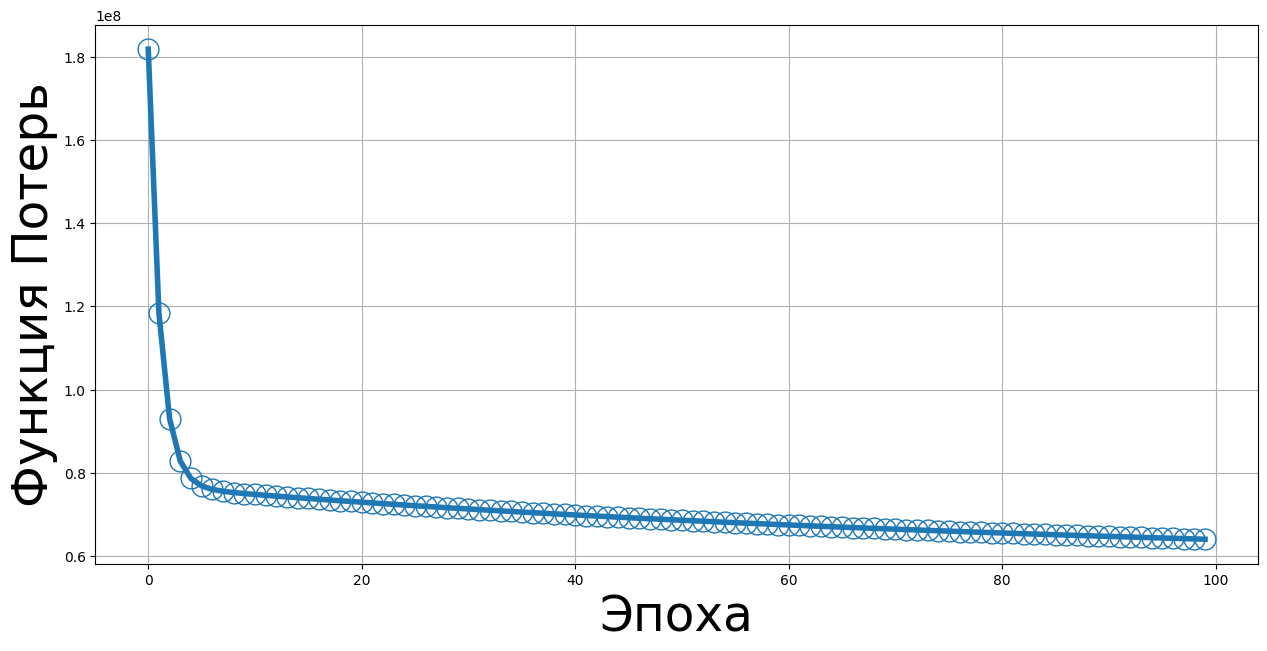

In [30]:
weights = weights_init(X_train.shape[1], random_state=42)

weights, cost = fit(X_train, y_train, weights, lr=0.9,  epochs=100)

fig  = plt.figure(figsize=(15,7))
plot_cost(cost)

Метрика  $R^2$ (проверка, как точно предсказывает функция)

In [31]:
def predict(weights, inputs):
    yhat = np.zeros(inputs.shape[0])
    
    for m in range(inputs.shape[0]):
        yhat[m] = inputs[m,:].dot(weights.T)
    
    return yhat

Посмотрим как выглядят наши ответы на фоне реальных

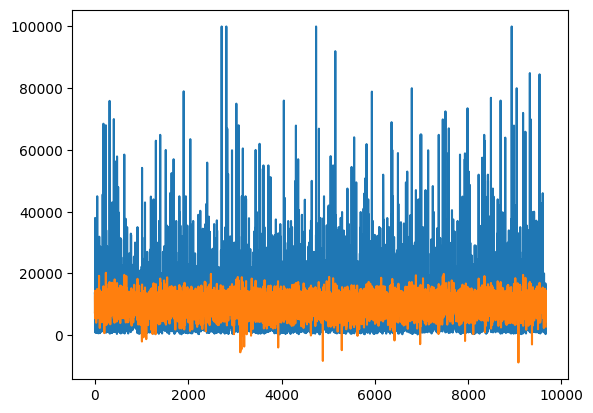

In [32]:
yhat = predict(weights, X_test)
plt.plot(y_test, label='original')
plt.plot(yhat, label='predicted');

Text(0, 0.5, 'predicted')

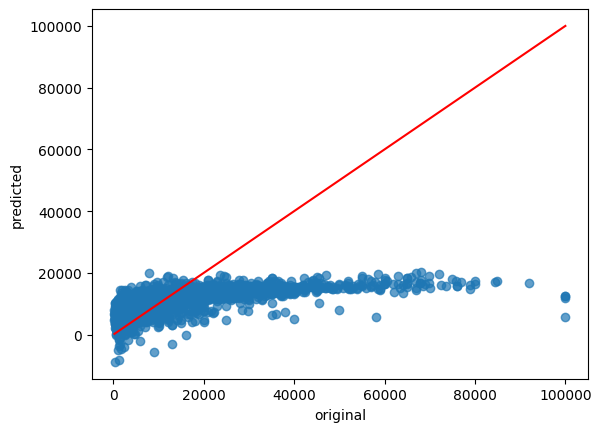

In [33]:
plt.scatter(y_test,yhat,alpha = 0.7)
plt.plot([y_test.min(),y_test.max()],[y_test.min(),y_test.max()], 'r')
plt.xlabel('original')
plt.ylabel('predicted')

In [34]:
def r2_score(weights, inputs, labels):
    predicts = predict(weights, inputs)
    return 1-np.sum(np.square(labels-predicts))/np.sum(np.square(labels-np.mean(labels)))

In [35]:
r2_score(weights, X_test, y_test)

0.30775705120132035

In [36]:
BATCH = 5000

def fit_SGD(X, y, weights, lr,  epochs=30, batch_size = BATCH, random_state = 42):
    
    np.random.seed(random_state)
    
    
    cost = np.zeros(epochs)
    for i in range(epochs): 
        
        grad = np.zeros(weights.shape)
        loss = 0
        
        idx_batch = np.random.randint(0,X.shape[0],batch_size)
        x_batch   = np.take(X, idx_batch, axis=0)
        y_batch   = np.take(y, idx_batch)

        
        for m in range(batch_size): 
            yhat  = forward(weights, x_batch[m,:])
            grad += grad_loss(yhat,  y_batch[m], x_batch[m,:])
            loss += loss_func(yhat,  y_batch[m])

        weights  = update_weights(grad/batch_size,weights, lr)  
        cost[i] =loss/batch_size
    
    return weights, cost

0.37078971359420776


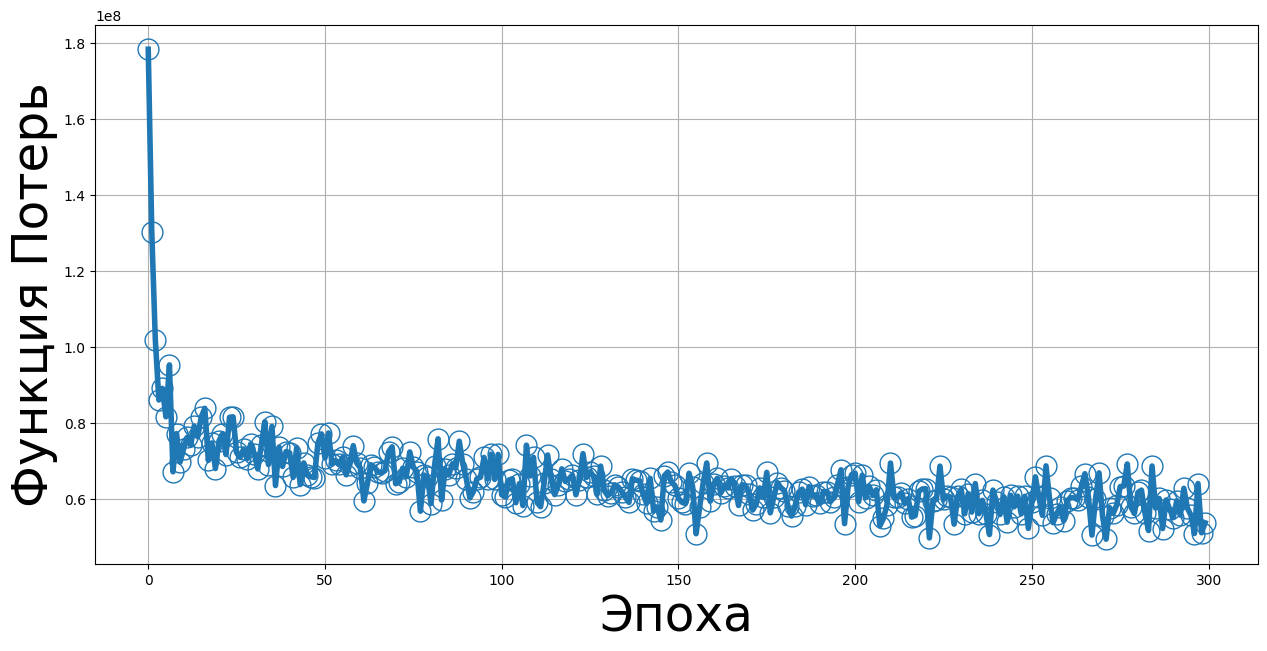

In [37]:
weights = weights_init(X_train.shape[1], random_state=42)

weights, cost = fit_SGD(X_train, y_train, weights, lr=0.7,  epochs=300)

fig  = plt.figure(figsize=(15,7))
plot_cost(cost)

print(r2_score(weights, X_test, y_test))

Обьединение всех частей в один класс линейной регресии

In [38]:
class LinearRegression():
    def __init__(self, 
                 learning_rate = 0.5, 
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000, 
                 random_state = 42):
        self.lr      = learning_rate
        self.epochs  = epochs
        self.weights = weights
        self.bias    = bias
        self.seed    = random_state
        self.batch_size = batch_size
        self.cost    = np.zeros(epochs)
        
        # если веса и смещения заданы
        if not(self.weights is None) and (self.bias):
            if self.weights.size == X.shape[1]:
            #совмещаем в один массив, если мы этого не сделали
                self.weights = np.append(self.bias,self.weights)
    
    #---------------------------------
    def forward(self, X):
        return self.weights.dot(X.T)
    
    #---------------------------------
    def loss(self,yhat, y):
        return np.square(yhat - y).sum()/y.size
    
    #---------------------------------
    def grad_step(self,yhat, y, X):
        return 2*np.dot(X.T, (yhat - y)) / y.size
    
    #---------------------------------
    def update(self):    
        return self.weights - self.lr*self.grad
    
    #---------------------------------
    def init(self, weights_size):
        np.random.seed(self.seed)
        return np.random.randn(weights_size)/np.sqrt(weights_size)
    
    #---------------------------------
    def add_bias(self, X):
        return np.column_stack((np.ones(X.shape[0]), X))

    #---------------------------------
    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        return yhat
    
    #---------------------------------
    def score(self, X, y):        
        yhat = self.predict(X)
        return 1-np.sum(np.square(y-yhat))/np.sum(np.square(y-np.mean(y)))

     #---------------------------------
    def load_batch(self,X,y):
        idx_batch = np.random.randint(0,X.shape[0],self.batch_size)
        x_batch   = np.take(X, idx_batch, axis=0)
        x_batch   = self.add_bias(x_batch)
        y_batch   = np.take(y, idx_batch)
        return  x_batch, y_batch

    #---------------------------------
    def fit(self, X, y):

        np.random.seed(self.seed)
        
        if self.weights is None:
            self.weights = self.init(X.shape[1])
        
        if self.bias is None: 
            self.bias    = self.init(1)
        
        if self.weights.size == X.shape[1]:
            #совмещаем в один массив, если мы этого не сделали
            self.weights = np.append(self.bias,self.weights)
        
        self.grad    = np.zeros(self.weights.shape)
        self.cost    = np.zeros(self.epochs)

        if self.batch_size is None:            
            x_batch   = self.add_bias(X)
            y_batch   = y
        
        for i in range(self.epochs): 

            if self.batch_size: 
                x_batch, y_batch = self.load_batch(X,y)

            yhat         = self.forward(x_batch)
            self.grad    = self.grad_step(yhat,  y_batch, x_batch) 
            self.weights = self.update()  
            self.cost[i] = self.loss(yhat,  y_batch)

        self.bias = self.weights[0]
     
    #---------------------------------
    def plot_cost(self, figsize = (12,6), title = ''):
        plt.figure(figsize = figsize)
        plt.plot(self.cost)
        plt.grid()
        plt.xlabel('Эпоха', fontsize = 24)
        plt.ylabel('Функция Потерь', fontsize = 24)
        plt.title(title, fontsize = 24)
        plt.show()
    
    #---------------------------------
    def get_w_and_b(self):
        return (self.weights[1:], self.bias)

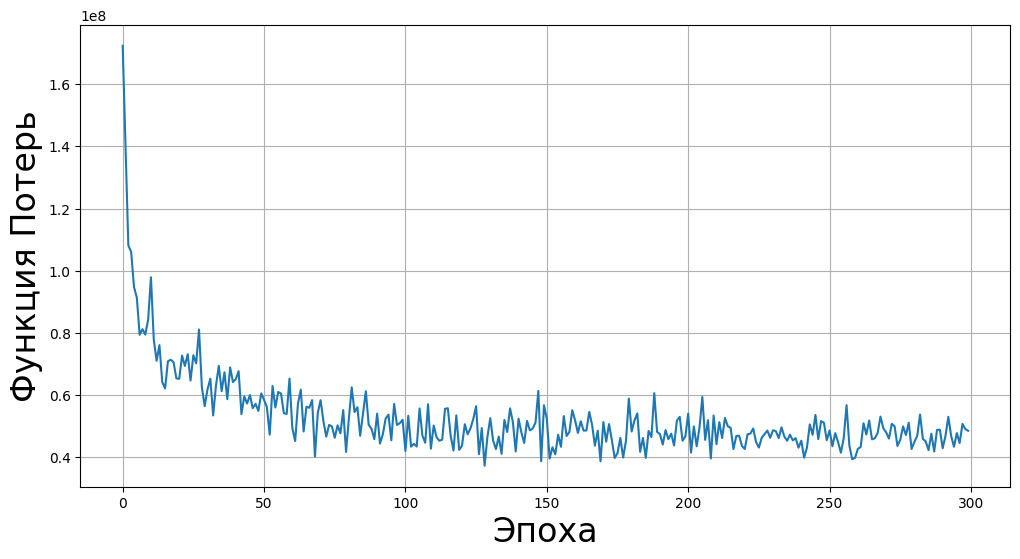

train R2: 0.4869; test R2: 0.4767


In [39]:
regr = LinearRegression(learning_rate=0.5,epochs=300,batch_size=3000)
regr.fit(X_train, y_train)

regr.plot_cost()

print( 'train R2: %.4f; test R2: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

In [41]:
def vis_weigths(weights, names):
    numbers = np.arange(0,len(weights))
    tick_labels = names
    cc=['']*len(numbers)
    for n,val in enumerate(weights):
        if val<0:
            cc[n]='red'
        elif val>=0:
            cc[n]='blue'

    plt.bar(x = numbers, height = weights, color = cc)
    plt.xticks(np.arange(0,len(weights)),tick_labels, rotation = 45 )

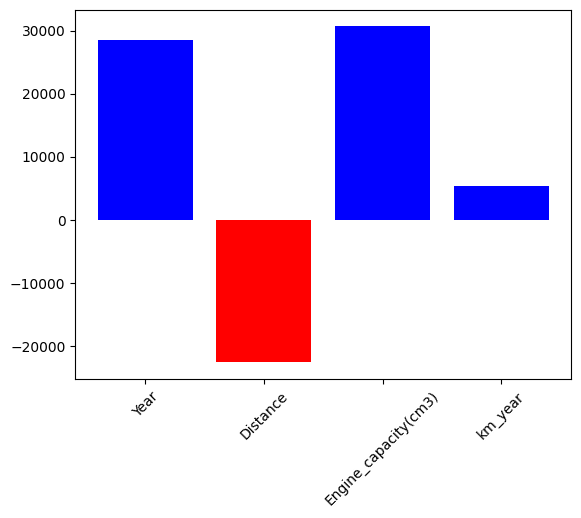

In [42]:
w, b = regr.get_w_and_b()

vis_weigths(w, features_names)

In [43]:
np.sum(np.abs(w))

86990.68957974161